# Задание к Уроку 6. Евграфов Михаил. Б03-913С2

## Используемые библиотеки. 

In [45]:
import matplotlib.pyplot as plt
import numpy as np

## Константы.

In [46]:
pair_contourf_len = 15
pair_len = 13
sqr_len = 12.8
width = 6.4

phi_beg, phi_end = 0, 2 * np.pi
r_beg, r_end = 1.15, 5
x_shift, y_shift = -0.15, 0

N_trans, N_rad = 100, 145

u_inf = 1
AoA = 20 / 180 * np.pi
c = 1

## Вспомогательные функции для расчётов.

In [47]:
def get_polar_grid(N_trans, N_rad, x_shift, y_shift,
                  r_beg, r_end, phi_beg, phi_end):
    
    phis = np.linspace(phi_beg, phi_end, N_rad)
    rs = np.linspace(r_beg, r_end, N_trans)
    
    RS, PHIS = np.meshgrid(rs, phis)
    
    X = RS * np.cos(PHIS) + x_shift
    Y = RS * np.sin(PHIS) + y_shift
    
    return X, Y

In [48]:
def calculate_transormation(z, c):
    
    return z + c ** 2 / z

In [49]:
def transform_grid(X, Y, c):
    
    Z = calculate_transormation(X + Y * 1j, c)
    
    return Z.real, Z.imag

In [50]:
def rotate_shift_grid(x0, y0, alpha, X0, Y0):
    
    X = (X0 - x0) * np.cos(alpha) + (Y0 - y0) * np.sin(alpha)
    Y = (Y0 - y0) * np.cos(alpha) - (X0 - x0) * np.sin(alpha)
    
    return X, Y

In [51]:
def rotate_velocity(u0, v0, alpha):
    
    u = u0 * np.cos(alpha) - v0 * np.sin(alpha)
    v = u0 * np.sin(alpha) + v0 * np.cos(alpha)
    
    return u, v

In [52]:
def transform_velocity(u, v, z, c):
    
    vz = (u - v * 1j) / (1 - (c / z) ** 2)
    
    return vz.real, -vz.imag

In [53]:
def calculate_dipole_intensity(R, u_inf):
    
    return 2 * np.pi * u_inf * R ** 2

In [54]:
def calculate_vortex_intensity(x, R, u_inf):
    
    return 4 * np.pi * u_inf * np.sqrt(R ** 2 - x ** 2)

In [55]:
def calculate_stream_dipole(kappa, x0, y0, X, Y):
    
    psi = - kappa / 2 / np.pi * (Y - y0) / ((X - x0) ** 2 + (Y - y0) ** 2)
    
    return psi

In [56]:
def calculate_stream_vortex(gamma, x0, y0, X, Y):
    
    psi = gamma / (4 * np.pi) * np.log((X - x0) ** 2 + (Y - y0) ** 2)
    
    return psi

In [57]:
def calculate_stream_velocity(_shape, u_inf, alpha):
    
    u = u_inf * np.ones(shape=_shape) * np.cos(alpha)
    v = u_inf * np.ones(shape=_shape) * np.sin(alpha)
    
    return u, v

In [58]:
def calculate_dipole_velocity(kappa, x0, y0, X, Y):
    
    U = kappa / 2 / np.pi * ((X - x0) ** 2 - (Y - y0) ** 2)
    V = kappa / 2 / np.pi * 2 * (X - x0) * (Y - y0)
    den = ((X - x0) ** 2 + (Y - y0) ** 2) ** 2
    
    return -U / den, -V / den

In [59]:
def calculate_vortex_velocity(gamma, x0, y0, X, Y):
    
    U = gamma / 2 / np.pi * (Y - y0) / ((X - x0) ** 2 + (Y - y0) ** 2)
    V = - gamma / 2 / np.pi * (X - x0) / ((X - x0) ** 2 + (Y - y0) ** 2)
    
    return U, V

In [60]:
def calculate_cp(U, V, u_inf):
    
    return 1 - (U ** 2 + V ** 2) / u_inf ** 2

## Вспомогательные функции для отрисовки.

In [61]:
def paint_scatter(ax, _title, X, Y, _color='b', _grid=False):
    
    ax.set_title(_title, fontsize=20, fontweight='bold')
    ax.set_xlabel('x', fontsize=15, fontweight='bold')
    ax.set_ylabel('y', fontsize=15, fontweight='bold')
    
    ax.scatter(X, Y, s=1, marker='o', color=_color)
    
    x_shift = abs(X.min() - X.max()) / 8
    y_shift = abs(Y.min() - Y.max()) / 8
    
    ax.set_xlim(X.min() - x_shift, X.max() + x_shift)
    ax.set_ylim(Y.min() - y_shift, Y.max() + y_shift)
    
    ax.grid(_grid)

In [62]:
def paint_contour(ax, _title, X, Y, Z, _color='k'):
    
    ax.set_title(_title, fontsize=20, fontweight='bold')
    ax.set_xlabel('x', fontsize=15, fontweight='bold')
    ax.set_ylabel('y', fontsize=15, fontweight='bold')
    
    ax.contour(X, Y, Z, colors='k', linestyles='solid', levels=50)
    
    x_shift = abs(X.min() - X.max()) / 8
    y_shift = abs(Y.min() - Y.max()) / 8
    
    ax.set_xlim(X.min() - x_shift, X.max() + x_shift)
    ax.set_ylim(Y.min() - y_shift, Y.max() + y_shift)

In [63]:
def paint_contourf(_ax, _title, _label, X, Y, Z, _cmap='jet'):
    
    _ax.set_title(_title, fontsize=20, fontweight='bold')
    _ax.set_xlabel('x', fontsize=15, fontweight='bold')
    _ax.set_ylabel('y', fontsize=15, fontweight='bold')
    
    contf = _ax.contourf(X, Y, Z, levels=np.linspace(-1, 1, 200), extend='both',
                         cmap=_cmap)
    cbar = plt.colorbar(contf, ax=_ax)
    
    cbar.set_label(_label, fontsize=16)
    cbar.set_ticks(np.arange(-0.88, 1, 0.22))

In [64]:
def paint_quiver(ax, _title, X, Y, U, V,):
    
    ax.set_title(_title, fontsize=20, fontweight='bold')
    ax.set_xlabel('x', fontsize=15, fontweight='bold')
    ax.set_ylabel('y', fontsize=15, fontweight='bold')
    
    ax.quiver(X[::4], Y[::4], U[::4], V[::4], scale=50)
    
    shift = abs(X.min() - X.max()) / 2 / np.sqrt(2) * (np.sqrt(2) - 1)
    
    ax.set_xlim(X.min() + shift, X.max() - shift)
    ax.set_ylim(Y.min() + shift, Y.max() - shift)

## Пункт 2. Введение в преобразование Жуковского. 

### Подпункт 2.1:

$ R = 1.5 $

$ C = 1 $

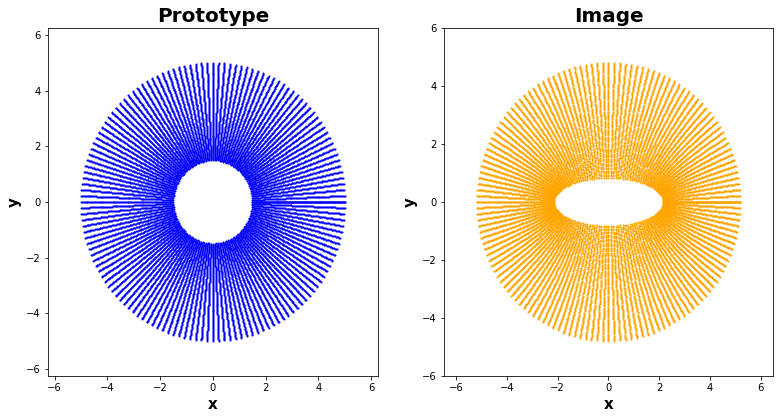

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

X0, Y0 = get_polar_grid(N_trans, N_rad, 0, 0, 
                        1.5, r_end, phi_beg, phi_end)
X1, X2 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0)
paint_scatter(axs[1], 'Image', X1, X2, _color='orange')

plt.show()

**Вывод**: При преобразовании Жуковского с данными параметрами окружность переходит в эллипс.

### Подпункт 2.2:

$ R = 1.2 $

$ C = 1 $

$ \Delta x_{c} = C - R $

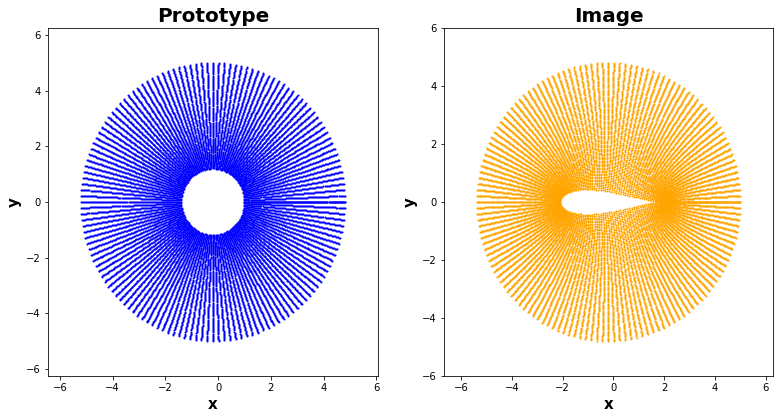

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

X0, Y0 = get_polar_grid(N_trans, N_rad, c - 1.2, 0, 
                        1.2, r_end, phi_beg, phi_end)
X1, X2 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0)
paint_scatter(axs[1], 'Image', X1, X2, _color='orange')

plt.show()

**Вывод**: При преобразовании Жуковского с данными параметрами окружность переходит в симметричный профиль.

### Подпункт 2.3:

$ R = \sqrt{(C - x_c)^2 + y_c^2} $

$ C = 1.5 $

$ \Delta x_{c} = -0.1 $

$ \Delta y_{c} = 0.1 $

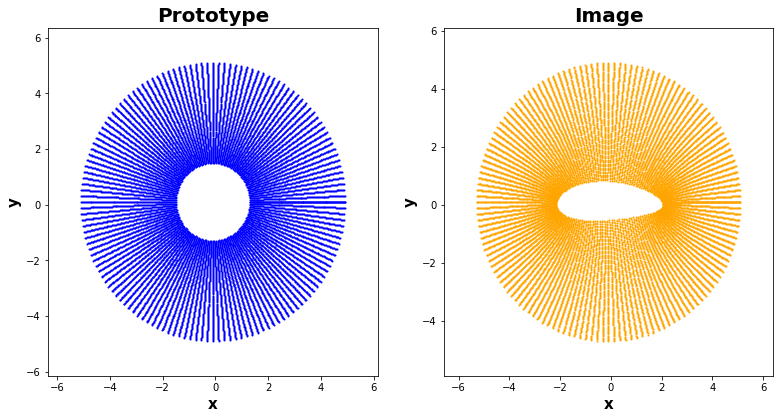

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

r = np.sqrt((1.5 - 0.1) ** 2 + 0.1 ** 2)

X0, Y0 = get_polar_grid(N_trans, N_rad, -0.1, 0.1, 
                        r, r_end, phi_beg, phi_end)
X1, X2 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0)
paint_scatter(axs[1], 'Image', X1, X2, _color='orange')

plt.show()

**Вывод**: При преобразовании Жуковского с данными параметрами окружность переходит в несимметричный профиль.

## Пункт 3. Получение расчётной сетки. 

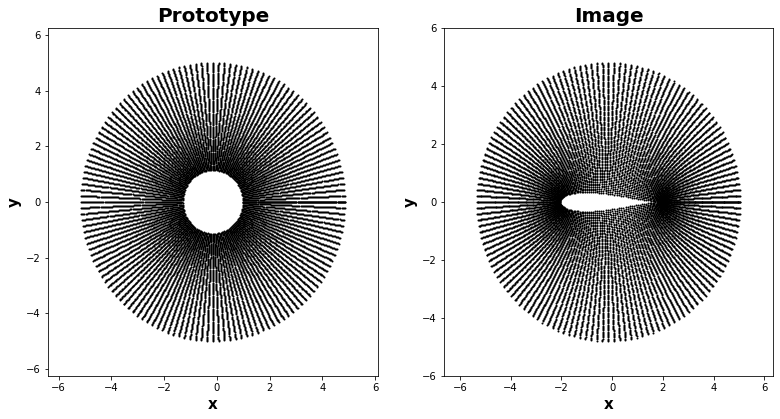

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

X0, Y0 = get_polar_grid(N_trans, N_rad, x_shift, y_shift,
                        r_beg, r_end, phi_beg, phi_end)
X1, Y1 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0, _color='k')
paint_scatter(axs[1], 'Image', X1, Y1, _color='k')

plt.show()

## Пункт 4. Обтекание симметричного профиля под нулевым углом атаки. 

### Подпункт 4.1. Функция тока. 

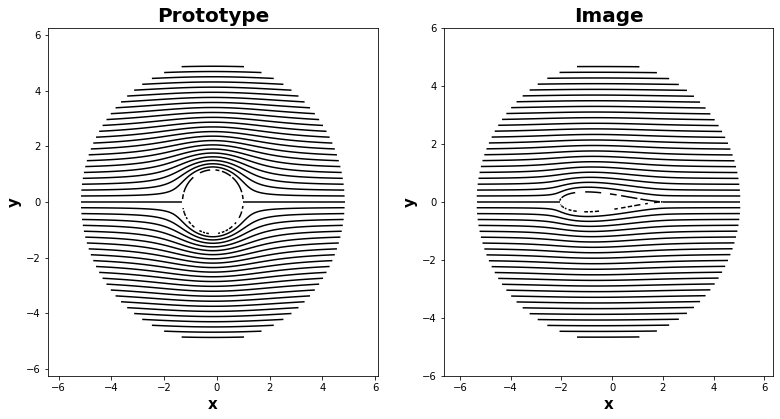

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

intensity = calculate_dipole_intensity(r_beg, u_inf)

psi_dipole0 = calculate_stream_dipole(intensity, x_shift, y_shift, X0, Y0)
psi_stream0 = u_inf * Y0
psi0 = psi_dipole0 + psi_stream0

paint_contour(axs[0], 'Prototype', X0, Y0, psi0)
paint_contour(axs[1], 'Image', X1, Y1, psi0)

### Подпункт 4.2. Поле скоростей. 

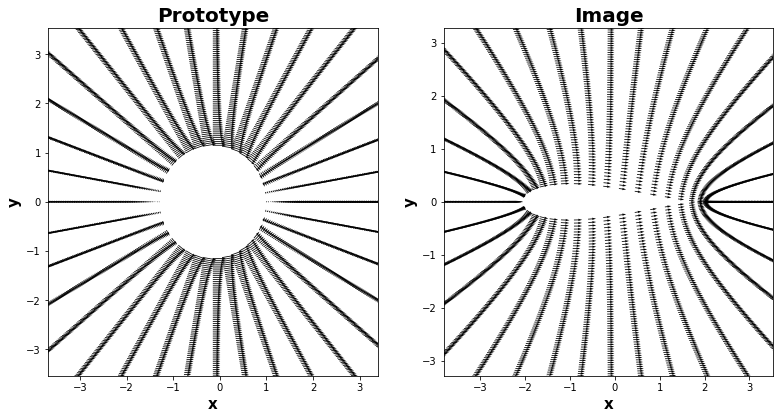

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

u0_dipole, v0_dipole = calculate_dipole_velocity(intensity, x_shift, y_shift, X0, Y0)
u0_stream, v0_stream = calculate_stream_velocity((N_rad, N_trans), u_inf, 0)
u0, v0 = u0_dipole + u0_stream, v0_dipole + v0_stream

u1, v1 = transform_velocity(u0, v0, X0 + Y0 * 1j, c)

paint_quiver(axs[0], 'Prototype', X0, Y0, u0, v0)
paint_quiver(axs[1], 'Image', X1, Y1, u1, v1)

### Подпункт 4.3. Распределение коэффициента давления.

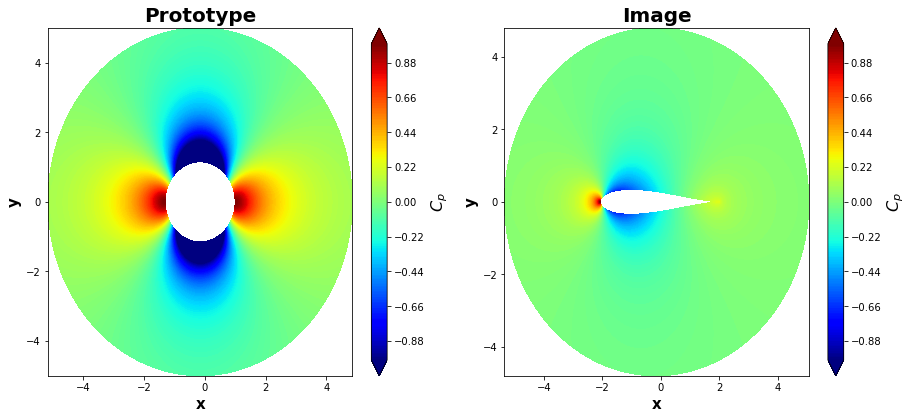

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(pair_contourf_len, width))

cp0 = calculate_cp(u0, v0, u_inf)
cp1 = calculate_cp(u1, v1, u_inf)

paint_contourf(axs[0], 'Prototype', '$C_p$', X0, Y0, cp0)
paint_contourf(axs[1], 'Image', '$C_p$', X1, Y1, cp1)

### Подпункт 4.4. Упражнения. 

**1. Интенсивность диполя: $\kappa = 8.31$**

In [72]:
print(f'intensity = {round(intensity, 2)}')

intensity = 8.31


**2. Скорость в 62-й точки: $V_{62} = 1.22$**

In [73]:
V62 = np.sqrt(u1[61][0] ** 2 + v1[61][0] ** 2)

print(f'V = {round(V62, 2)}')

V = 1.22


**3. Минимальное значение коэффициента давления на поверхности профиля: $ C_p = -0.69$**

In [74]:
print(f'Cp_min = {round(cp1.min(), 2)}')

Cp_min = -0.69


## Пункт 5. Обтекание симметричного профиля  под ненулевым углом атаки, без циркуляции.

### Подпункт 5.1. Функция тока. 

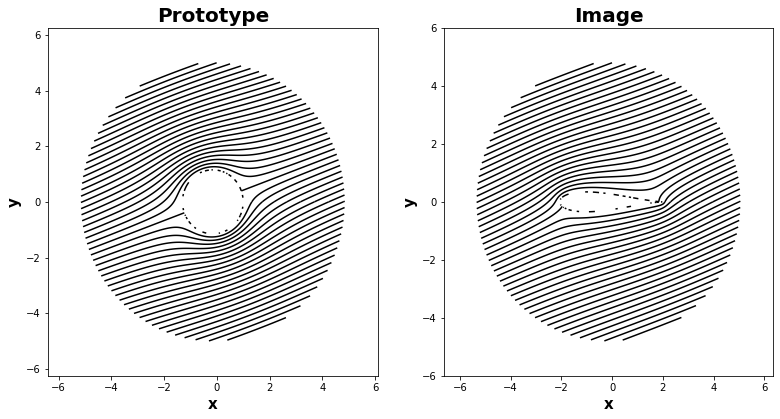

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

X0_, Y0_ = rotate_shift_grid(x_shift, y_shift ,AoA, X0, Y0)

psi_dipole0 = calculate_stream_dipole(intensity, 0, 0, X0_, Y0_)
psi_stream0 = u_inf * Y0_
psi0 = psi_dipole0 + psi_stream0

paint_contour(axs[0], 'Prototype', X0, Y0, psi0)
paint_contour(axs[1], 'Image', X1, Y1, psi0)

### Подпункт 5.2. Поле скоростей.

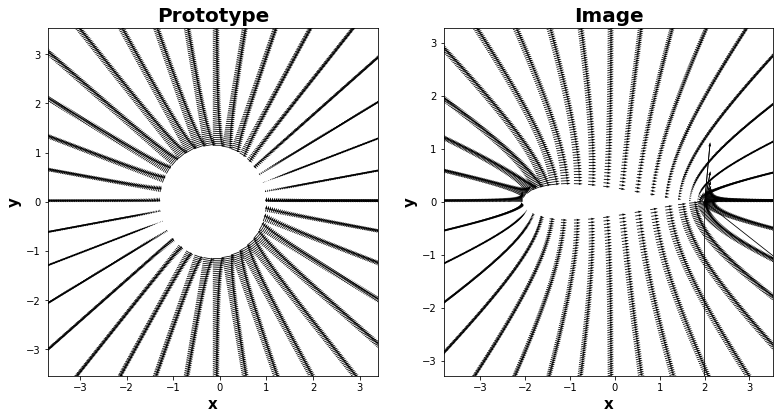

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

u0_dipole_, v0_dipole_ = calculate_dipole_velocity(intensity, 0, 0, X0_, Y0_)
u0_stream_, v0_stream_ = calculate_stream_velocity((N_rad, N_trans), u_inf, 0)
u0_, v0_ = u0_dipole_ + u0_stream_, v0_dipole_ + v0_stream_

u0, v0 = rotate_velocity(u0_, v0_, AoA)
u1, v1 = transform_velocity(u0, v0, X0 + Y0 * 1j, c)

paint_quiver(axs[0], 'Prototype', X0, Y0, u0, v0)
paint_quiver(axs[1], 'Image', X1, Y1, u1, v1)

### Подпункт 5.3. Распределение коэффициента давления.

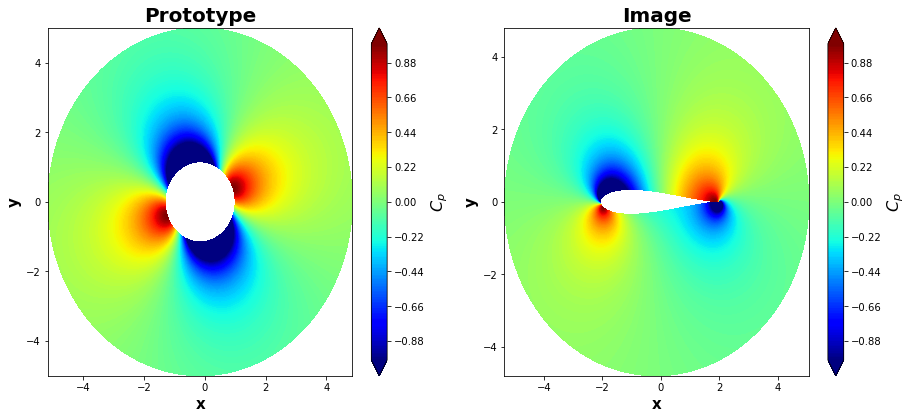

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(pair_contourf_len, width))

cp0 = calculate_cp(u0, v0, u_inf)
cp1 = calculate_cp(u1, v1, u_inf)

paint_contourf(axs[0], 'Prototype', '$C_p$', X0, Y0, cp0)
paint_contourf(axs[1], 'Image', '$C_p$', X1, Y1, cp1)

### Подпункт 5.4. Упражнения. 

**1. Физично ли полученное решение?**

Нет, не физично. Обоснования:
>**По полю скоростей**: наблюдается бесконечная скорость на задней кромке.

>**По распределению коэффициента давления**: наблюдается чёткое разграничение давлений в точке пространства, не принадлежащей крылу. 

**2. Расположение точек торможения: $p_1 = 9; p_2 = 81$**

In [78]:
V1 = np.round(np.sqrt(v1[:, 0] ** 2 + u1[:, 0] ** 2), 3)

stang_points = np.where(V1 == 0)[0] + 1

print(f'first point = {stang_points[0]}',
     f'second point = {stang_points[-1]}', sep='\n')

first point = 9
second point = 81


**3. Значение подъёмной силы: $L = 0$**

**4. Значение коэффициента сопротивления: $C_L = 0 $**

Т.к. давление распределено симметрично относительно осей x' и y'.

**5. Скорость в 50-й точки: $V_{50} = 1.49$**

In [79]:
V50 = np.sqrt(u1[49][0] ** 2 + v1[49][0] ** 2)

print(f'V = {round(V50, 2)}')

V = 1.49


**6. Коэффициента давления в 75-й точке: $C_p = -0.49$**

In [80]:
cp75 = cp1[74][0]

print(f'Cp = {round(cp75, 2)}')

Cp = -0.49


## Пункт 6. Обтекание симметричного профиля под ненулевым углом атаки при наличии циркуляции.

### Подпункт 6.1. Функция тока.

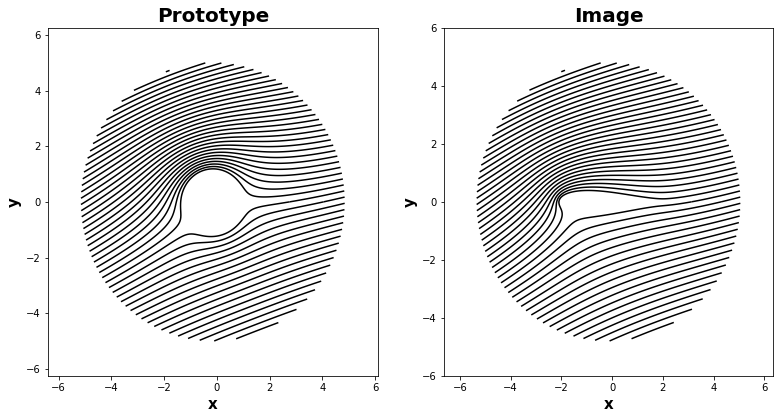

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

x0, _ = rotate_shift_grid(x_shift, y_shift, AoA, 1, 0)

gamma = calculate_vortex_intensity(x0, r_beg, u_inf)

X0_, Y0_ = rotate_shift_grid(x_shift, y_shift ,AoA, X0, Y0)

psi_dipole0 = calculate_stream_dipole(intensity, 0, 0, X0_, Y0_)
psi_vortex0 = calculate_stream_vortex(gamma, 0, 0, X0_, Y0_)
psi_stream0 = u_inf * Y0_
psi0 = psi_dipole0 + psi_vortex0 + psi_stream0

paint_contour(axs[0], 'Prototype', X0, Y0, psi0)
paint_contour(axs[1], 'Image', X1, Y1, psi0)

### Подпункт 6.2. Поле скоростей.

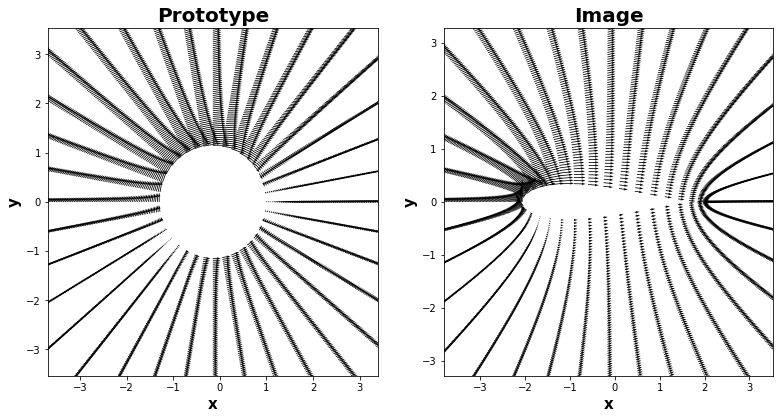

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

u0_dipole_, v0_dipole_ = calculate_dipole_velocity(intensity, 0, 0, X0_, Y0_)
u0_vortex_, v0_vortex_ = calculate_vortex_velocity(gamma, 0, 0, X0_, Y0_)
u0_stream_, v0_stream_ = calculate_stream_velocity((N_rad, N_trans), u_inf, 0)
u0_ = u0_dipole_ + u0_vortex_ + u0_stream_ 
v0_ = v0_dipole_ + v0_vortex_ + v0_stream_

u0, v0 = rotate_velocity(u0_, v0_, AoA)
u1, v1 = transform_velocity(u0, v0, X0 + Y0 * 1j, c)

paint_quiver(axs[0], 'Prototype', X0, Y0, u0, v0)
paint_quiver(axs[1], 'Image', X1, Y1, u1, v1)

### Подпункт 6.3. Распределение коэффициента давления.

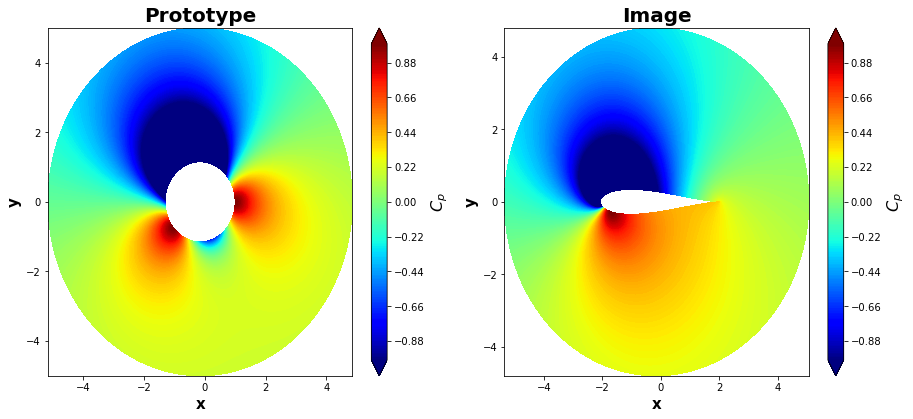

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(pair_contourf_len, width))

cp0 = calculate_cp(u0, v0, u_inf)
cp1 = calculate_cp(u1, v1, u_inf)

paint_contourf(axs[0], 'Prototype', '$C_p$', X0, Y0, cp0)
paint_contourf(axs[1], 'Image', '$C_p$', X1, Y1, cp1)

### Подпункт 6.4. Упражнения. 

**1. Интенсивность вихря: $\Gamma = 4.94$**

In [84]:
print(f'Intensity = {round(gamma, 2)}')

Intensity = 4.94


**2. Значение подъёмной силы: $L = 4.94$**

In [85]:
L = u_inf * gamma

print(f' L = {round(L, 2)}')

 L = 4.94


**3. Вычисление подъёмной силы и сопротивления напрямую:**

Интеграл по поверхности профиля тождественно равен нуля, т.к. в расчётах не учитывается вязкость. Получили парадокс Даламбера. Да, удовлетворяет. 

**4. Расположение точек торможения: $p = 89$**

In [86]:
V1 = np.round(np.sqrt(v1[:, 0] ** 2 + u1[:, 0] ** 2), 3)

points = np.where(V1 == 0)[0] + 1

print(f'point = {points[0]}')

point = 89


**5. Скорость в 92-й точки: $V_{92} = 0.21$**

In [87]:
V92 = np.sqrt(u1[91][0] ** 2 + v1[91][0] ** 2)

print(f'V = {round(V92, 2)}')

V = 0.21


**6. Коэффициент давления в 111-й точке: $C_p = 0.5$** 

In [44]:
cp111 = cp1[110][0]

print(f'Cp = {round(cp111, 2)}')

Cp = 0.5


**7. Что происходит с коэффициентом давления на задней кромке?**

Коэффициент давления плавно уменьшается. 